In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# --- Preprocessing & VIF ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Modeling & Splitting ---
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, KFold, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor

import optuna

# --- Metrics ---
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer
)

# --- Settings ---
pd.set_option("display.max_columns", None)
print("All libraries imported.")

pd.set_option("display.max_columns", None)

# create model folder
os.makedirs("models", exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.20

# --- Updated: We'll now manage imputation inside the pipeline ---
DROP_COLS = ['country_name','wp_revenue_USD']

All libraries imported.


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1

## 1. Data Loading and Pre-Processing Pipeline

This notebook implements the complete preprocessing workflow used in the study.  
All steps described below correspond to the “Methods” section of the paper, but the
technical details are provided here to keep the manuscript concise.

### **1.1 Dataset and Loading**
The analysis uses a merged multi-country water-point dataset containing:
- geospatial attributes  
- infrastructure characteristics  
- rainfall (previous-year CHIRPS monthly values)  
- population density buffers  
- revenue records collected by the field teams  

The dataset is loaded from a local CSV file and inspected for shape and structure.

---

### **1.2 Revenue Tiering for Stage-1 Classification**
To enable a two-stage modelling structure, continuous revenue is mapped into three  
economically meaningful classes:

- **Class 0:** 0–5 USD (very low revenue)  
- **Class 1:** 5–500 USD (typical operating revenue)  
- **Class 2:** >500 USD (high outlier systems)

These thresholds reflect the empirical distribution of revenue across Africa and
support a stable first-stage classifier.

---

### **1.3 Feature Groups**

We define two explicit feature sets:

- **Numeric variables:** geospatial coordinates, infrastructure variables, monthly rainfall, water-point proximity metrics, and population-density buffers.

- **Categorical variables:** system type, revenue model, metering methodology, and legal status.

Columns known to cause **data leakage** (e.g., IDs, revenue itself, provider metadata, and administrative fields) are excluded entirely.

---

### **1.4 Multicollinearity Control (Iterative VIF Elimination)**  
To minimise instability in tree-based models and avoid redundant predictors,
numeric features undergo iterative VIF (Variance Inflation Factor) elimination.
Features with VIF > 10 are removed in descending order until all remaining
predictors fall below the threshold.

This method reduces structural collinearity without manual variable selection.

---

### **1.5 Preprocessing Pipeline**

A unified scikit-learn `ColumnTransformer` ensures reproducible transformations:

- **Numeric pipeline**  
  - Median imputation  
  - Standard scaling  

- **Categorical pipeline**  
  - Constant-value imputation ("missing")  
  - One-Hot Encoding (`handle_unknown="ignore"`)  

This avoids leakage and enforces identical preprocessing during training and inference.

---

### **1.6 Train/Test Split**

Data is partitioned using an 80/20 stratified split on the revenue class labels.
Stratification ensures balanced representation of rare high-revenue systems.

The regression target (`wp_revenue_USD`) is aligned with the same indices for Stage-2 modelling.

---

The code cell below implements these procedures exactly.


In [19]:
# --- Load Data ---
file_path =r"C:\Users\User\OneDrive\Desktop\Data_Science\Uptime\Python_Scripts\science_water_revenue_paradox\data\analysis_dataset.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please update the 'file_path' variable to point to your CSV.")

df.head()

Successfully loaded data from C:\Users\User\OneDrive\Desktop\Data_Science\Uptime\Python_Scripts\science_water_revenue_paradox\data\analysis_dataset.csv
Data shape: (11957, 44)


,year,lat,lon,num_taps,num_hh,wp_pop_last,num_kiosks,num_scheme_tanks,wp_revenue_model,volume_method,country_name,wp_m3,wp_revenue_USD,quarters_used,wp_type_cat,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,wp_count_within_500m,wp_count_within_1000m,wp_count_within_2000m,wp_count_within_10000m,wp_count_within_20000m,pop_served_last_within_500m,pop_served_last_within_1000m,pop_served_last_within_2000m,pop_served_last_within_5000m,pop_served_last_within_10000m,pop_served_last_within_20000m,Population_Within_500m,Population_Within_1000m,Population_Within_2000m,Population_Within_5000m,Population_Within_10000m,Population_Within_20000m
0,2022,0.0,0.0,0,0,540,0.0,NaN,waterpoint,estimated,5,6840.0,0.00,"1,2,3,4",Handpump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2,22,52,4260.0,4260.0,4260.0,21640.0,45840.0,114180.0,635.089419,849.061005,1881.180785,16765.475450,55627.78571,169661.8942
1,2022,0.0,0.0,0,0,275,NaN,NaN,waterpoint,NaN,9,0.0,105.84,"1,2,3,4",Handpump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,9,28,0.0,0.0,0.0,2700.0,9160.0,24060.0,79.817419,478.904515,1755.983222,6819.277203,26224.43827,149319.3699
2,2022,0.0,0.0,0,0,185,NaN,NaN,waterpoint,NaN,9,0.0,227.53,"1,2,3,4",Handpump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,7,23,0.0,0.0,0.0,1700.0,8000.0,22420.0,136.829861,444.697050,1961.228015,3808.431144,22356.77814,122863.8512
3,2022,0.0,0.0,0,0,200,NaN,NaN,waterpoint,NaN,9,0.0,12.96,"1,2,3,4",Handpump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,12,25,0.0,0.0,0.0,2140.0,11760.0,22360.0,34.207465,136.829861,330.672165,5872.281555,27901.58570,113420.6097
4,2022,0.0,0.0,0,0,180,NaN,NaN,waterpoint,NaN,9,0.0,92.74,"1,2,3,4",Handpump,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,17,29,0.0,0.0,0.0,3400.0,15200.0,25040.0,182.439815,505.864986,1647.278299,11283.372050,36935.64020,170057.1148


In [3]:
# --- Helper Function ---
def revenue_to_class(val):
    if val <= 5:
        return 0
    elif val <= 500:
        return 1
    else:
        return 2

# --- Feature Definitions ---
# We must explicitly define our feature lists for the pipelines
NUMERIC_FEATURES = [
    'year', 'lat', 'lon', 'num_taps', 'num_hh', 'wp_pop_last', 'num_kiosks', 
    'num_scheme_tanks', 'month_1', 'month_2', 'month_3', 
    'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
    'month_11', 'month_12', 'wp_count_within_500m', 'wp_count_within_1000m', 
    'wp_count_within_2000m', 'wp_count_within_10000m', 'wp_count_within_20000m', 
    'pop_served_last_within_500m', 'pop_served_last_within_1000m', 
    'pop_served_last_within_2000m', 'pop_served_last_within_5000m', 
    'pop_served_last_within_10000m', 'pop_served_last_within_20000m', 
    'Population_Within_500m', 'Population_Within_1000m', 'Population_Within_2000m', 
    'Population_Within_5000m', 'Population_Within_10000m', 'Population_Within_20000m'
]

CATEGORICAL_FEATURES = [
    'wp_type_cat', 'wp_revenue_model', 'volume_method',
]

# Columns to drop to prevent data leakage
DROP_COLS = ['country_name','quarters_used','volume_method','wp_m3',
            'wp_revenue_USD','target_class']

print("Feature lists and helper function defined.")

Feature lists and helper function defined.


In [4]:
# --- VIF CHECK ---
# Iterative VIF Elimination
print("--- Starting Iterative VIF Elimination ---")

# Define our threshold
vif_threshold = 10

current_features = NUMERIC_FEATURES.copy()
features_removed = []

while True:
    # 1. Prepare data for VIF
    # VIF can't handle NaNs, so we impute with 0 *only* for this check
    vif_data = df[current_features].fillna(0)
    
    # 2. Calculate VIF for all current features
    vif_df = pd.DataFrame()
    vif_df["feature"] = current_features
    vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    
    # 3. Find the max VIF
    max_vif_row = vif_df.sort_values('VIF', ascending=False).iloc[0]
    max_vif = max_vif_row['VIF']
    feature_to_remove = max_vif_row['feature']
    
    # 4. Check the condition
    if max_vif < vif_threshold:
        # If the highest VIF is now below our threshold, we are done
        print(f"\nAll remaining features have VIF below {vif_threshold}. Process complete.")
        break
    else:
        # If not, remove the highest VIF feature and repeat
        print(f"Removing feature: {feature_to_remove} (VIF: {max_vif:.2f})")
        current_features.remove(feature_to_remove)
        features_removed.append(feature_to_remove)

# 5. Update the global NUMERIC_FEATURES list
NUMERIC_FEATURES = current_features

print("\n--- Features removed due to high VIF ---")
print(features_removed)

print("\n--- Final list of Numeric Features (low multicollinearity) ---")
print(NUMERIC_FEATURES)

c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


--- Starting Iterative VIF Elimination ---
Removing feature: pop_served_last_within_10000m (VIF: 40.65)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing feature: Population_Within_1000m (VIF: 38.23)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing feature: wp_count_within_1000m (VIF: 24.79)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing feature: wp_count_within_10000m (VIF: 20.16)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing feature: pop_served_last_within_2000m (VIF: 16.64)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


Removing feature: Population_Within_10000m (VIF: 12.25)


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



All remaining features have VIF below 10. Process complete.

--- Features removed due to high VIF ---
['pop_served_last_within_10000m', 'Population_Within_1000m', 'wp_count_within_1000m', 'wp_count_within_10000m', 'pop_served_last_within_2000m', 'Population_Within_10000m']

--- Final list of Numeric Features (low multicollinearity) ---
['year', 'lat', 'lon', 'num_taps', 'num_hh', 'wp_pop_last', 'num_kiosks', 'num_scheme_tanks', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'wp_count_within_500m', 'wp_count_within_2000m', 'wp_count_within_20000m', 'pop_served_last_within_500m', 'pop_served_last_within_1000m', 'pop_served_last_within_5000m', 'pop_served_last_within_20000m', 'Population_Within_500m', 'Population_Within_2000m', 'Population_Within_5000m', 'Population_Within_20000m']


In [5]:
# --- Numeric Pipeline ---
# 1. Impute missing values with the median
# 2. Scale features using StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) 
])

# --- Categorical Pipeline ---
# 1. Impute missing values with a constant "missing"
# 2. One-hot encode categories (handles unseen values at prediction time)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Combine pipelines using ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop' # Drop any columns not in our lists
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


In [6]:
# --- Create Target Variables ---
df['target_class'] = df['wp_revenue_USD'].apply(revenue_to_class)
y_classification = df['target_class']
y_regression = df['wp_revenue_USD'] # The true revenue for stage 2

# --- Define Features (X) ---
# We keep only the features our preprocessor knows about
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = df[FEATURES]

# --- Create Train/Test Splits ---
# We split the data into train and test sets
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_classification, 
    test_size=TEST_SIZE, 
    stratify=y_classification, 
    random_state=RANDOM_STATE
)

# We need the regression targets to be aligned with the train/test sets
y_train_reg = y_regression.loc[X_train.index]
y_test_reg = y_regression.loc[X_test.index]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_class shape: {y_train_class.shape}")
print(f"y_test_reg shape: {y_test_reg.shape}")
print(X_train.columns)

X_train shape: (9565, 34)
X_test shape: (2392, 34)
y_train_class shape: (9565,)
y_test_reg shape: (2392,)
Index(['year', 'lat', 'lon', 'num_taps', 'num_hh', 'wp_pop_last', 'num_kiosks',
       'num_scheme_tanks', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'wp_count_within_500m', 'wp_count_within_2000m',
       'wp_count_within_20000m', 'pop_served_last_within_500m',
       'pop_served_last_within_1000m', 'pop_served_last_within_5000m',
       'pop_served_last_within_20000m', 'Population_Within_500m',
       'Population_Within_2000m', 'Population_Within_5000m',
       'Population_Within_20000m', 'wp_type_cat', 'wp_revenue_model',
       'volume_method'],
      dtype='object')


## 2. Stage-1 Model Training and Hyperparameter Optimization

This section documents the technical procedure used to train and tune the Stage-1
classification model. The conceptual motivation for the two-stage framework is described
in the paper; here we provide the reproducible implementation details.

### **2.1 Model Choice**
A Decision Tree classifier was selected for Stage-1 because:

- it is interpretable and well-aligned with policy-driven decision-making,  
- it handles mixed numeric/categorical data without requiring excessive feature engineering,  
- it produces stable class boundaries needed for the subsequent regression stage.

The model is wrapped inside a unified scikit-learn `Pipeline` to ensure that
preprocessing (imputation, scaling, and one-hot encoding) is consistently applied
within cross-validation, preventing train–test leakage.

---

### **2.2 Hyperparameter Search (Optuna)**

We tune three core tree parameters using Optuna:

- **max_depth**  
- **min_samples_split**  
- **min_samples_leaf**

These parameters control structural complexity and prevent overfitting, which is
especially important given the cross-country heterogeneity in the training data.

A **5-fold stratified cross-validation** loop evaluates each candidate configuration
using **macro-F1**, which gives equal importance to low-frequency classes and matches
the objective described in the manuscript.

Optuna conducts 50 trials and returns the configuration that maximizes mean CV
macro-F1. This reduces manual tuning, ensures reproducibility, and provides a
statistically grounded model selection procedure.

---

### **2.3 Final Model Fitting**
After selecting the optimal set of parameters, the classifier is retrained on the
entire training partition. All preprocessing transformations are included inside the
pipeline, ensuring that the final fitted model is identical to the one evaluated
during cross-validation.

---

### **2.4 Evaluation Metrics**

We evaluate performance on both the train and test sets using:

- **Classification report:** per-class precision, recall, F1  
- **Macro-F1 score:** the primary metric used throughout the paper  
- **ROC-AUC (one-vs-rest):** a complementary measure of separability across classes  

These metrics directly correspond to the results reported in the manuscript.

---

The code cell below implements the complete optimization, training, and
evaluation pipeline for Stage-1 classification.


In [7]:
# ==========================================
# Objective Function for Optuna
# ==========================================
def objective(trial):

    # Optuna hyperparameters
    max_depth = trial.suggest_int("max_depth", 5, 40)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)

    # Build pipeline with sampled params
    clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=RANDOM_STATE
        ))
    ])

    # Cross-validation (5-fold)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scores = cross_val_score(
        clf_pipeline,
        X_train,
        y_train_class,
        scoring='f1_macro',
        cv=cv,
        n_jobs=-1
    )

    return scores.mean()

# ==========================================
# Run the Optuna Study
# ==========================================
study = optuna.create_study(
    direction="maximize",
    study_name="dtree_opt"
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n====================")
print("Best Hyperparameters")
print("====================")
print(study.best_params)
print(f"Best CV F1-Macro: {study.best_value:.4f}")

# ==========================================
# Retrain Best Model on Full Train Set
# ==========================================
best_params = study.best_params

best_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        **best_params,
        random_state=RANDOM_STATE
    ))
])

best_clf.fit(X_train, y_train_class)

# ==========================================
# TRAIN Evaluation
# ==========================================
print("\n=== TRAIN SET PERFORMANCE ===")
y_pred_train = best_clf.predict(X_train)
y_proba_train = best_clf.predict_proba(X_train)

print(classification_report(y_train_class, y_pred_train))
print(f"Train F1 Macro: {f1_score(y_train_class, y_pred_train, average='macro'):.4f}")

try:
    train_auc = roc_auc_score(y_train_class, y_proba_train, multi_class="ovr")
    print(f"Train ROC-AUC: {train_auc:.4f}")
except:
    pass

# ==========================================
# TEST Evaluation
# ==========================================
print("\n=== TEST SET PERFORMANCE ===")
y_pred_test = best_clf.predict(X_test)
y_proba_test = best_clf.predict_proba(X_test)

print(classification_report(y_test_class, y_pred_test))
print(f"Test F1 Macro: {f1_score(y_test_class, y_pred_test, average='macro'):.4f}")

try:
    test_auc = roc_auc_score(y_test_class, y_proba_test, multi_class="ovr")
    print(f"Test ROC-AUC: {test_auc:.4f}")
except:
    pass

[I 2026-01-26 02:34:47,601] A new study created in memory with name: dtree_opt
Best trial: 0. Best value: 0.77423:   2%|▏         | 1/50 [00:03<02:30,  3.08s/it]

[I 2026-01-26 02:34:50,671] Trial 0 finished with value: 0.7742298641017793 and parameters: {'max_depth': 39, 'min_samples_split': 44, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.7742298641017793.


Best trial: 0. Best value: 0.77423:   4%|▍         | 2/50 [00:06<02:43,  3.41s/it]

[I 2026-01-26 02:34:54,315] Trial 1 finished with value: 0.7655179549563151 and parameters: {'max_depth': 29, 'min_samples_split': 28, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7742298641017793.


Best trial: 0. Best value: 0.77423:   6%|▌         | 3/50 [00:10<02:47,  3.57s/it]

[I 2026-01-26 02:34:58,079] Trial 2 finished with value: 0.7742298641017793 and parameters: {'max_depth': 37, 'min_samples_split': 35, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.7742298641017793.


Best trial: 3. Best value: 0.777501:   8%|▊         | 4/50 [00:14<02:46,  3.61s/it]

[I 2026-01-26 02:35:01,764] Trial 3 finished with value: 0.7775014664391349 and parameters: {'max_depth': 13, 'min_samples_split': 47, 'min_samples_leaf': 16}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  10%|█         | 5/50 [00:17<02:42,  3.61s/it]

[I 2026-01-26 02:35:05,373] Trial 4 finished with value: 0.7664917010814877 and parameters: {'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 43}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  12%|█▏        | 6/50 [00:21<02:38,  3.60s/it]

[I 2026-01-26 02:35:08,949] Trial 5 finished with value: 0.7716169481941508 and parameters: {'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 34}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  14%|█▍        | 7/50 [00:24<02:27,  3.44s/it]

[I 2026-01-26 02:35:12,044] Trial 6 finished with value: 0.776499313147476 and parameters: {'max_depth': 31, 'min_samples_split': 43, 'min_samples_leaf': 25}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  16%|█▌        | 8/50 [00:25<01:46,  2.53s/it]

[I 2026-01-26 02:35:12,643] Trial 7 finished with value: 0.7763598451611237 and parameters: {'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 23}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  18%|█▊        | 9/50 [00:25<01:16,  1.86s/it]

[I 2026-01-26 02:35:13,043] Trial 8 finished with value: 0.7638850179380603 and parameters: {'max_depth': 30, 'min_samples_split': 22, 'min_samples_leaf': 1}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 3. Best value: 0.777501:  20%|██        | 10/50 [00:25<00:55,  1.39s/it]

[I 2026-01-26 02:35:13,356] Trial 9 finished with value: 0.7329792768173028 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 38}. Best is trial 3 with value: 0.7775014664391349.


Best trial: 10. Best value: 0.7829:  22%|██▏       | 11/50 [00:26<00:41,  1.07s/it] 

[I 2026-01-26 02:35:13,714] Trial 10 finished with value: 0.7829004463733338 and parameters: {'max_depth': 14, 'min_samples_split': 49, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  24%|██▍       | 12/50 [00:26<00:31,  1.20it/s]

[I 2026-01-26 02:35:13,994] Trial 11 finished with value: 0.7800570131278179 and parameters: {'max_depth': 13, 'min_samples_split': 50, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  26%|██▌       | 13/50 [00:26<00:24,  1.49it/s]

[I 2026-01-26 02:35:14,297] Trial 12 finished with value: 0.7819476715241174 and parameters: {'max_depth': 16, 'min_samples_split': 50, 'min_samples_leaf': 11}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  28%|██▊       | 14/50 [00:27<00:21,  1.70it/s]

[I 2026-01-26 02:35:14,697] Trial 13 finished with value: 0.7782439321557304 and parameters: {'max_depth': 17, 'min_samples_split': 35, 'min_samples_leaf': 11}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  30%|███       | 15/50 [00:27<00:19,  1.77it/s]

[I 2026-01-26 02:35:15,211] Trial 14 finished with value: 0.7735768593824508 and parameters: {'max_depth': 18, 'min_samples_split': 38, 'min_samples_leaf': 8}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  32%|███▏      | 16/50 [00:27<00:16,  2.12it/s]

[I 2026-01-26 02:35:15,464] Trial 15 finished with value: 0.7708587576028226 and parameters: {'max_depth': 9, 'min_samples_split': 22, 'min_samples_leaf': 17}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  34%|███▍      | 17/50 [00:28<00:14,  2.24it/s]

[I 2026-01-26 02:35:15,851] Trial 16 finished with value: 0.7723949648857577 and parameters: {'max_depth': 20, 'min_samples_split': 41, 'min_samples_leaf': 30}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  36%|███▌      | 18/50 [00:28<00:13,  2.38it/s]

[I 2026-01-26 02:35:16,211] Trial 17 finished with value: 0.7725780872542789 and parameters: {'max_depth': 14, 'min_samples_split': 49, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  38%|███▊      | 19/50 [00:28<00:12,  2.54it/s]

[I 2026-01-26 02:35:16,539] Trial 18 finished with value: 0.767562897404819 and parameters: {'max_depth': 8, 'min_samples_split': 29, 'min_samples_leaf': 16}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  40%|████      | 20/50 [00:29<00:11,  2.54it/s]

[I 2026-01-26 02:35:16,929] Trial 19 finished with value: 0.7771276592205214 and parameters: {'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  42%|████▏     | 21/50 [00:29<00:10,  2.73it/s]

[I 2026-01-26 02:35:17,226] Trial 20 finished with value: 0.7685378350847862 and parameters: {'max_depth': 16, 'min_samples_split': 33, 'min_samples_leaf': 49}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  44%|████▍     | 22/50 [00:30<00:10,  2.69it/s]

[I 2026-01-26 02:35:17,613] Trial 21 finished with value: 0.777639853877771 and parameters: {'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 10}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  46%|████▌     | 23/50 [00:30<00:10,  2.62it/s]

[I 2026-01-26 02:35:18,027] Trial 22 finished with value: 0.773377010433599 and parameters: {'max_depth': 14, 'min_samples_split': 46, 'min_samples_leaf': 1}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  48%|████▊     | 24/50 [00:30<00:09,  2.89it/s]

[I 2026-01-26 02:35:18,285] Trial 23 finished with value: 0.7598567351980685 and parameters: {'max_depth': 7, 'min_samples_split': 41, 'min_samples_leaf': 18}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  50%|█████     | 25/50 [00:31<00:09,  2.75it/s]

[I 2026-01-26 02:35:18,697] Trial 24 finished with value: 0.7774952494222704 and parameters: {'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 13}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  52%|█████▏    | 26/50 [00:31<00:08,  2.77it/s]

[I 2026-01-26 02:35:19,052] Trial 25 finished with value: 0.7769238964546086 and parameters: {'max_depth': 19, 'min_samples_split': 39, 'min_samples_leaf': 28}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  54%|█████▍    | 27/50 [00:31<00:07,  2.94it/s]

[I 2026-01-26 02:35:19,331] Trial 26 finished with value: 0.7737177808603806 and parameters: {'max_depth': 23, 'min_samples_split': 45, 'min_samples_leaf': 6}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  56%|█████▌    | 28/50 [00:32<00:07,  2.88it/s]

[I 2026-01-26 02:35:19,703] Trial 27 finished with value: 0.77401750030508 and parameters: {'max_depth': 11, 'min_samples_split': 47, 'min_samples_leaf': 19}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  58%|█████▊    | 29/50 [00:32<00:07,  2.64it/s]

[I 2026-01-26 02:35:20,162] Trial 28 finished with value: 0.7819476715241174 and parameters: {'max_depth': 16, 'min_samples_split': 50, 'min_samples_leaf': 11}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  60%|██████    | 30/50 [00:32<00:07,  2.79it/s]

[I 2026-01-26 02:35:20,468] Trial 29 finished with value: 0.7765911121527148 and parameters: {'max_depth': 16, 'min_samples_split': 44, 'min_samples_leaf': 8}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  62%|██████▏   | 31/50 [00:33<00:07,  2.69it/s]

[I 2026-01-26 02:35:20,869] Trial 30 finished with value: 0.775551784094778 and parameters: {'max_depth': 26, 'min_samples_split': 43, 'min_samples_leaf': 21}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  64%|██████▍   | 32/50 [00:33<00:06,  2.64it/s]

[I 2026-01-26 02:35:21,270] Trial 31 finished with value: 0.7791978940809442 and parameters: {'max_depth': 13, 'min_samples_split': 50, 'min_samples_leaf': 13}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  66%|██████▌   | 33/50 [00:33<00:05,  2.86it/s]

[I 2026-01-26 02:35:21,547] Trial 32 finished with value: 0.770592723562482 and parameters: {'max_depth': 15, 'min_samples_split': 47, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  68%|██████▊   | 34/50 [00:34<00:05,  2.75it/s]

[I 2026-01-26 02:35:21,946] Trial 33 finished with value: 0.7803720797986835 and parameters: {'max_depth': 18, 'min_samples_split': 38, 'min_samples_leaf': 10}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  70%|███████   | 35/50 [00:34<00:05,  2.70it/s]

[I 2026-01-26 02:35:22,333] Trial 34 finished with value: 0.7734443664643023 and parameters: {'max_depth': 21, 'min_samples_split': 32, 'min_samples_leaf': 9}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  72%|███████▏  | 36/50 [00:35<00:05,  2.66it/s]

[I 2026-01-26 02:35:22,723] Trial 35 finished with value: 0.7675085259132489 and parameters: {'max_depth': 18, 'min_samples_split': 37, 'min_samples_leaf': 5}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  74%|███████▍  | 37/50 [00:35<00:04,  2.69it/s]

[I 2026-01-26 02:35:23,081] Trial 36 finished with value: 0.7805260400192962 and parameters: {'max_depth': 22, 'min_samples_split': 40, 'min_samples_leaf': 14}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  76%|███████▌  | 38/50 [00:35<00:04,  2.69it/s]

[I 2026-01-26 02:35:23,446] Trial 37 finished with value: 0.7765101410347978 and parameters: {'max_depth': 25, 'min_samples_split': 41, 'min_samples_leaf': 16}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  78%|███████▊  | 39/50 [00:36<00:04,  2.60it/s]

[I 2026-01-26 02:35:23,863] Trial 38 finished with value: 0.7814915064183148 and parameters: {'max_depth': 22, 'min_samples_split': 46, 'min_samples_leaf': 15}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  80%|████████  | 40/50 [00:36<00:03,  2.60it/s]

[I 2026-01-26 02:35:24,250] Trial 39 finished with value: 0.7757880557087701 and parameters: {'max_depth': 28, 'min_samples_split': 47, 'min_samples_leaf': 21}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  82%|████████▏ | 41/50 [00:37<00:03,  2.59it/s]

[I 2026-01-26 02:35:24,643] Trial 40 finished with value: 0.776499313147476 and parameters: {'max_depth': 38, 'min_samples_split': 44, 'min_samples_leaf': 25}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  84%|████████▍ | 42/50 [00:37<00:03,  2.64it/s]

[I 2026-01-26 02:35:25,006] Trial 41 finished with value: 0.7813999566671133 and parameters: {'max_depth': 35, 'min_samples_split': 48, 'min_samples_leaf': 15}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  86%|████████▌ | 43/50 [00:37<00:02,  2.72it/s]

[I 2026-01-26 02:35:25,348] Trial 42 finished with value: 0.7813999566671133 and parameters: {'max_depth': 35, 'min_samples_split': 48, 'min_samples_leaf': 15}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  88%|████████▊ | 44/50 [00:38<00:02,  2.70it/s]

[I 2026-01-26 02:35:25,714] Trial 43 finished with value: 0.7749725535913539 and parameters: {'max_depth': 33, 'min_samples_split': 45, 'min_samples_leaf': 19}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  90%|█████████ | 45/50 [00:38<00:01,  2.76it/s]

[I 2026-01-26 02:35:26,064] Trial 44 finished with value: 0.7661485530433145 and parameters: {'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  92%|█████████▏| 46/50 [00:38<00:01,  2.64it/s]

[I 2026-01-26 02:35:26,483] Trial 45 finished with value: 0.7709375465481408 and parameters: {'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 11}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  94%|█████████▍| 47/50 [00:39<00:01,  2.75it/s]

[I 2026-01-26 02:35:26,800] Trial 46 finished with value: 0.7738060551176076 and parameters: {'max_depth': 23, 'min_samples_split': 43, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  96%|█████████▌| 48/50 [00:39<00:00,  2.67it/s]

[I 2026-01-26 02:35:27,206] Trial 47 finished with value: 0.7740420508260107 and parameters: {'max_depth': 36, 'min_samples_split': 48, 'min_samples_leaf': 36}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829:  98%|█████████▊| 49/50 [00:39<00:00,  2.65it/s]

[I 2026-01-26 02:35:27,589] Trial 48 finished with value: 0.7756110581270814 and parameters: {'max_depth': 32, 'min_samples_split': 48, 'min_samples_leaf': 23}. Best is trial 10 with value: 0.7829004463733338.


Best trial: 10. Best value: 0.7829: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


[I 2026-01-26 02:35:27,896] Trial 49 finished with value: 0.7767168174730846 and parameters: {'max_depth': 20, 'min_samples_split': 42, 'min_samples_leaf': 20}. Best is trial 10 with value: 0.7829004463733338.

Best Hyperparameters
{'max_depth': 14, 'min_samples_split': 49, 'min_samples_leaf': 12}
Best CV F1-Macro: 0.7829

=== TRAIN SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      4250
           1       0.81      0.77      0.79      4549
           2       0.86      0.92      0.89       766

    accuracy                           0.81      9565
   macro avg       0.82      0.84      0.83      9565
weighted avg       0.81      0.81      0.81      9565

Train F1 Macro: 0.8293
Train ROC-AUC: 0.9378

=== TEST SET PERFORMANCE ===
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1063
           1       0.74      0.71      0.73      1137
           2       0.84   

## 3. LOCO Calibration and Local Data Adaptation Analysis

This section documents the experimental procedure used to quantify how much
country-specific data is required to adapt a globally trained model to a new region.
The conceptual motivation for this experiment is discussed in the manuscript; here we
provide the precise, reproducible implementation details.

### **3.1 Leave-One-Country-Out (LOCO) Framework**
For each country, the model is trained on all *other* countries (global prior) and then
evaluated on a held-out test split from the target country. This simulates deployment
into a region where no historical revenue information is available.

We gradually introduce small batches of local samples  
$k \in \{0, 10, 25, 50, 100, 150, 200, 300, 400, 500\}$  
to measure how performance improves as the model receives country-specific data.

### **3.2 Calibration Sampling Procedure**
Within each country:

- A fixed test set is created (minimum 200 samples where available).  
- The remaining samples form a calibration pool.  
- Samples are added **cumulatively** (`0 → 10 → 25 → … → k`) using a fixed random
  permutation.  
- At each calibration size, a new model is trained on:  
  **global data + first $k$ calibration samples from the held-out country**.

This produces smooth learning curves that show how rapidly a model adapts to new regions.

### **3.3 Evaluation Metrics**
Each calibration step is evaluated with:

- **Accuracy**  
- **Balanced Accuracy**  
- **Macro-F1 (primary metric)**  

Macro-F1 weights each class equally, which is essential in imbalanced multi-class settings.

### **3.4 Definition of “95% Gain”**
To quantify how much data is *enough*, we compute the smallest $k$ that achieves
95% of the total possible improvement from calibration.

Let:

- $ \text{F1}_{\text{baseline}} $ = performance at $k=0$  
- $ \text{F1}_{\max} $ = best performance across all $k$  

The 95% threshold is given by:

$$
\text{F1}(k) \ge \text{F1}_{\text{baseline}} 
+ 0.95 \cdot (\text{F1}_{\max} - \text{F1}_{\text{baseline}})
$$

The smallest $k$ satisfying this inequality defines  
**$k_{\text{needed}}^{95\%}$**, the minimum calibration effort required for deployment.

### **3.5 Mean Curves and Elbow Analysis**
We average learning curves across countries and compute an elbow point using a
maximum-distance-to-chord method. This identifies the moment where adding more
local data produces diminishing returns — supporting the conclusions presented in
the manuscript regarding calibration efficiency and data transferability.

---

The code below implements the full LOCO calibration, computes the 95% thresholds,
and generates the elbow plot.


In [8]:
# ==========================================
# LOCO CALIBRATION EXPERIMENT (UPDATED)
# ==========================================
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state

COUNTRY_COL = "country_name"
TARGET_COL  = "target_class"
RANDOM_STATE = 42
K_GRID = [0, 10, 25, 50, 100, 150, 200, 300, 400, 500]
MIN_TEST_ROWS = 200
PRIMARY_METRIC = "f1_macro"

df["country_name"] = df["country_name"].astype(str)

# -------------------------------
# Build model from best params
# -------------------------------
def build_loco_model(best_params):
    return Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", DecisionTreeClassifier(
            **best_params,
            random_state=RANDOM_STATE
        ))
    ])

# -------------------------------
# Metrics
# -------------------------------
def eval_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

# -------------------------------
# Compute k needed for 95% gain
# -------------------------------
def compute_k_needed(curve_df, metric=PRIMARY_METRIC, pct_of_gain=0.95):
    dfc = curve_df.sort_values("rows_added").dropna(subset=[metric])

    if (dfc["rows_added"] == 0).any():
        baseline = float(dfc[dfc["rows_added"] == 0][metric].iloc[0])
    else:
        baseline = float(dfc[metric].iloc[0])

    max_val = float(dfc[metric].max())
    target = baseline + pct_of_gain * (max_val - baseline)

    hit = dfc[dfc[metric] >= target]
    if hit.empty:
        return None
    return int(hit["rows_added"].iloc[0])


# -------------------------------
# LOCO MAIN
# -------------------------------
def run_loco_calibration(df, best_params):
    rng = check_random_state(RANDOM_STATE)
    countries = df[COUNTRY_COL].astype(str).unique().tolist()

    curves_all = []
    summary_rows = []

    for country in countries:
        df_c = df[df[COUNTRY_COL] == country].copy()
        n_c = len(df_c)

        df_train_pool = df[df[COUNTRY_COL] != country].copy()

        idx = df_c.index.to_numpy()
        rng.shuffle(idx)

        if n_c >= MIN_TEST_ROWS:
            test_idx = idx[:MIN_TEST_ROWS]
        else:
            test_idx = idx[:max(1, n_c // 3)]

        calib_pool_idx = np.setdiff1d(idx, test_idx)

        df_c_test = df_c.loc[test_idx]
        df_c_pool = df_c.loc[calib_pool_idx]

        y_test = df_c_test[TARGET_COL].values

        calib_idx_sorted = rng.permutation(df_c_pool.index.to_numpy())

        max_k = max(0, len(calib_pool_idx) - 1)
        k_list = [k for k in K_GRID if k <= max_k]
        if 0 not in k_list:
            k_list.insert(0, 0)

        for k in k_list:
            calib_idx = calib_idx_sorted[:k]
            df_c_calib = df_c_pool.loc[calib_idx] if k > 0 else df_c_pool.iloc[0:0]

            df_train = pd.concat([df_train_pool, df_c_calib], axis=0)

            X_train = df_train[FEATURES]
            y_train = df_train[TARGET_COL]
            X_test = df_c_test[FEATURES]

            model = build_loco_model(best_params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            metrics = eval_metrics(y_test, y_pred)

            curves_all.append({
                "country": country,
                "rows_added": int(k),
                "n_country": n_c,
                "n_test": len(df_c_test),
                **metrics
            })

        curve_df = pd.DataFrame([c for c in curves_all if c["country"] == country])
        curve_df = curve_df.sort_values("rows_added")

        zero = float(curve_df[curve_df["rows_added"] == 0][PRIMARY_METRIC].iloc[0])
        best_v = float(curve_df[PRIMARY_METRIC].max())
        k_needed = compute_k_needed(curve_df, PRIMARY_METRIC, pct_of_gain=0.95)

        summary_rows.append({
            "country": country,
            "n_rows": n_c,
            "zero_shot_f1": zero,
            "best_f1": best_v,
            "k_needed_95pct_gain": k_needed
        })

    return pd.DataFrame(summary_rows), pd.DataFrame(curves_all)



# ==========================================
# RUN LOCO EXPERIMENT
# ==========================================
summary_df, curves_df = run_loco_calibration(df, best_params)

print("=== LOCO Summary ===")
display(summary_df)

print("=== LOCO Curves ===")
display(curves_df.head())


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\sklearn\metrics\_classification.py:2776: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


=== LOCO Summary ===


c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\User\anaconda3\envs\Uptime_MVP\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


,country,n_rows,zero_shot_f1,best_f1,k_needed_95pct_gain
0,5,1151,0.548440,0.664589,300
1,9,2687,0.440897,0.670917,400
2,7,783,0.157395,0.542826,300
3,10,407,0.378109,0.474474,150
4,2,802,0.483360,0.546382,400
5,6,856,0.501398,0.815538,100
6,1,4556,0.415025,0.565657,400
7,3,463,0.534056,0.744483,150
8,8,51,0.569697,0.569697,0
9,0,177,0.587995,0.587995,0


=== LOCO Curves ===


,country,rows_added,n_country,n_test,accuracy,balanced_accuracy,f1_macro
0,5,0,1151,200,0.560,0.551502,0.548440
1,5,10,1151,200,0.550,0.543563,0.542264
2,5,25,1151,200,0.555,0.549643,0.549036
3,5,50,1151,200,0.530,0.512913,0.490017
4,5,100,1151,200,0.525,0.514571,0.508167


## 4. Temporal Window Evaluation

This stage investigates how predictive performance changes when the model is
trained on different historical periods, enabling us to understand whether older
data continues to provide value or introduces temporal drift. Before conducting
the temporal window study, **column-wise drift diagnostics were performed in
`drift.ipynb`**, where feature distributions were compared across years to detect
shifts that might impact downstream model training. These drift findings provide
the motivation for evaluating how restricting or expanding the training window
affects generalization.

### 4.1 Methodology

For each window \([Y_{\text{start}},\, Y_{\text{end}}]\), the dataset is filtered to include
only those years. Within the selected window:

- The revenue variable is converted into the classification target  
  using thresholds defined earlier.
- The original preprocessing pipeline is reused to ensure consistency.
- A Decision Tree classifier is tuned with Optuna, using  
  5-fold stratified cross-validation and **macro-F1** as the optimization metric.

The Optuna objective is:

$$
\max_{\theta \in \Theta}
\; \mathrm{F1}_{\mathrm{CV}}(\theta)
$$

where

$$
\theta = \{ \text{max\_depth},\ \text{min\_samples\_split},\ \text{min\_samples\_leaf} \}.
$$


After hyperparameter optimization, the best model is retrained on the full training
subset and evaluated on a held-out 20% test split.

### 4.2 Metrics

For each window, we report:

- **Macro-F1**, which treats all revenue classes equally and is robust to imbalance,
- **Multiclass ROC-AUC**, computed using a one-vs-rest formulation.

These metrics quantify how well the model generalizes to unseen samples within
the same temporal window.

### 4.3 Purpose of This Analysis

The temporal window experiments complement both the drift diagnostics and the
LOCO calibration study by clarifying:

- Whether **older historical data remains useful**,  
- Whether **model performance improves when restricting training to more recent years**,  
- Whether **full-window training (2021–2024)** provides the strongest and most stable
predictive performance.

Together with the findings from `drift.ipynb`, this section helps identify the
**most reliable training horizon** while minimizing the influence of potentially
shifted or outdated feature distributions.


In [9]:
def evaluate_window(df, start_year, end_year, n_trials=30):
    print(f"\n\n==============================")
    print(f" Evaluating Window: {start_year} → {end_year}")
    print(f"==============================")

    # Subset data
    df_win = df[(df["year"] >= start_year) & (df["year"] <= end_year)].copy()

    # Create target
    df_win["target_class"] = df_win["wp_revenue_USD"].apply(revenue_to_class)

    X_win = df_win[FEATURES]
    y_win = df_win["target_class"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_win, y_win, test_size=TEST_SIZE, stratify=y_win, random_state=RANDOM_STATE
    )

    # ----- Optuna objective -----
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 5, 40),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        }

        clf = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', DecisionTreeClassifier(**params, random_state=RANDOM_STATE))
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        scores = cross_val_score(
            clf, X_train, y_train,
            scoring="f1_macro",
            cv=cv, n_jobs=-1
        )

        return scores.mean()

    # ----- Run Optuna -----
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params

    # Train final model
    best_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE))
    ])

    best_model.fit(X_train, y_train)

    # Evaluate
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F1-Macro: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")

    return {
        "window": f"{start_year}-{end_year}",
        "f1_macro": f1,
        "roc_auc": auc,
        "params": best_params
    }


In [10]:
results = []

results.append(evaluate_window(df, 2021, 2024))
results.append(evaluate_window(df, 2022, 2024))
results.append(evaluate_window(df, 2023, 2024))
results.append(evaluate_window(df, 2024, 2024))

results_df = pd.DataFrame(results)
results_df

[I 2026-01-26 02:35:47,511] A new study created in memory with name: no-name-c6b103fa-ebff-48ca-b1b2-ccbbe45ae987




 Evaluating Window: 2021 → 2024


[I 2026-01-26 02:35:47,780] Trial 0 finished with value: 0.7664472057156908 and parameters: {'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 42}. Best is trial 0 with value: 0.7664472057156908.
[I 2026-01-26 02:35:48,015] Trial 1 finished with value: 0.7749709295425582 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 18}. Best is trial 1 with value: 0.7749709295425582.
[I 2026-01-26 02:35:48,260] Trial 2 finished with value: 0.7820906293716441 and parameters: {'max_depth': 25, 'min_samples_split': 47, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.7820906293716441.
[I 2026-01-26 02:35:48,507] Trial 3 finished with value: 0.7724302724716379 and parameters: {'max_depth': 32, 'min_samples_split': 49, 'min_samples_leaf': 33}. Best is trial 2 with value: 0.7820906293716441.
[I 2026-01-26 02:35:48,738] Trial 4 finished with value: 0.7667513193991096 and parameters: {'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 50}. Best is t


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1063
           1       0.74      0.70      0.72      1137
           2       0.85      0.92      0.88       192

    accuracy                           0.74      2392
   macro avg       0.77      0.79      0.78      2392
weighted avg       0.74      0.74      0.74      2392

F1-Macro: 0.7776
ROC-AUC: 0.8871


 Evaluating Window: 2022 → 2024


[I 2026-01-26 02:35:55,076] Trial 0 finished with value: 0.7613008992881605 and parameters: {'max_depth': 36, 'min_samples_split': 38, 'min_samples_leaf': 30}. Best is trial 0 with value: 0.7613008992881605.
[I 2026-01-26 02:35:55,297] Trial 1 finished with value: 0.7628707861158391 and parameters: {'max_depth': 37, 'min_samples_split': 44, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7628707861158391.
[I 2026-01-26 02:35:55,507] Trial 2 finished with value: 0.7639701221325028 and parameters: {'max_depth': 26, 'min_samples_split': 31, 'min_samples_leaf': 38}. Best is trial 2 with value: 0.7639701221325028.
[I 2026-01-26 02:35:55,730] Trial 3 finished with value: 0.7684853422158388 and parameters: {'max_depth': 34, 'min_samples_split': 31, 'min_samples_leaf': 21}. Best is trial 3 with value: 0.7684853422158388.
[I 2026-01-26 02:35:55,952] Trial 4 finished with value: 0.7626443128995877 and parameters: {'max_depth': 31, 'min_samples_split': 13, 'min_samples_leaf': 35}. Best is t


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       976
           1       0.76      0.72      0.74      1134
           2       0.85      0.89      0.87       171

    accuracy                           0.75      2281
   macro avg       0.78      0.79      0.78      2281
weighted avg       0.75      0.75      0.75      2281

F1-Macro: 0.7810
ROC-AUC: 0.8879


 Evaluating Window: 2023 → 2024


[I 2026-01-26 02:36:01,843] Trial 0 finished with value: 0.760737767700429 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.760737767700429.
[I 2026-01-26 02:36:02,125] Trial 1 finished with value: 0.7680627718722832 and parameters: {'max_depth': 27, 'min_samples_split': 28, 'min_samples_leaf': 34}. Best is trial 1 with value: 0.7680627718722832.
[I 2026-01-26 02:36:02,315] Trial 2 finished with value: 0.7683855444982746 and parameters: {'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 35}. Best is trial 2 with value: 0.7683855444982746.
[I 2026-01-26 02:36:02,593] Trial 3 finished with value: 0.7668436217031194 and parameters: {'max_depth': 28, 'min_samples_split': 32, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7683855444982746.
[I 2026-01-26 02:36:02,840] Trial 4 finished with value: 0.7544533050788271 and parameters: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 34}. Best is trial 2


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       657
           1       0.80      0.67      0.73       689
           2       0.85      0.96      0.90       117

    accuracy                           0.76      1463
   macro avg       0.79      0.82      0.80      1463
weighted avg       0.77      0.76      0.76      1463

F1-Macro: 0.7996
ROC-AUC: 0.8914


 Evaluating Window: 2024 → 2024


[I 2026-01-26 02:36:07,950] Trial 3 finished with value: 0.7341670467127875 and parameters: {'max_depth': 12, 'min_samples_split': 37, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.7341670467127875.
[I 2026-01-26 02:36:07,997] Trial 4 finished with value: 0.7305877461119878 and parameters: {'max_depth': 32, 'min_samples_split': 4, 'min_samples_leaf': 31}. Best is trial 3 with value: 0.7341670467127875.
[I 2026-01-26 02:36:08,046] Trial 5 finished with value: 0.729406027319202 and parameters: {'max_depth': 34, 'min_samples_split': 7, 'min_samples_leaf': 47}. Best is trial 3 with value: 0.7341670467127875.
[I 2026-01-26 02:36:08,093] Trial 6 finished with value: 0.7323147487352089 and parameters: {'max_depth': 38, 'min_samples_split': 42, 'min_samples_leaf': 28}. Best is trial 3 with value: 0.7341670467127875.
[I 2026-01-26 02:36:08,141] Trial 7 finished with value: 0.7309758689305744 and parameters: {'max_depth': 10, 'min_samples_split': 29, 'min_samples_leaf': 44}. Best is tri


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       343
           1       0.72      0.53      0.61       251
           2       0.86      0.97      0.91        58

    accuracy                           0.74       652
   macro avg       0.77      0.78      0.77       652
weighted avg       0.74      0.74      0.73       652

F1-Macro: 0.7705
ROC-AUC: 0.8673


,window,f1_macro,roc_auc,params
0,2021-2024,0.777563,0.887128,"{'max_depth': 30, 'min_samples_split': 43, 'mi..."
1,2022-2024,0.780998,0.887922,"{'max_depth': 15, 'min_samples_split': 29, 'mi..."
2,2023-2024,0.799647,0.891377,"{'max_depth': 8, 'min_samples_split': 29, 'min..."
3,2024-2024,0.770492,0.867333,"{'max_depth': 10, 'min_samples_split': 43, 'mi..."


In [11]:
results_df.sort_values("roc_auc", ascending=False)

,window,f1_macro,roc_auc,params
2,2023-2024,0.799647,0.891377,"{'max_depth': 8, 'min_samples_split': 29, 'min..."
1,2022-2024,0.780998,0.887922,"{'max_depth': 15, 'min_samples_split': 29, 'mi..."
0,2021-2024,0.777563,0.887128,"{'max_depth': 30, 'min_samples_split': 43, 'mi..."
3,2024-2024,0.770492,0.867333,"{'max_depth': 10, 'min_samples_split': 43, 'mi..."


## 5. Learning Curve Analysis

This section presents the learning curve diagnostics for the Optuna-optimized
Decision Tree classifier. Learning curves quantify how model performance scales
with additional training data and help identify whether limitations arise from
underfitting, overfitting, or insufficient sample size.

### **5.1 Methodology**
We compute training and validation macro-F1 scores across progressively larger
subsets of the training set. For each training size:

1. The model is retrained using the full preprocessing pipeline  
2. Five stratified folds are used to evaluate macro-F1  
3. Mean and standard deviation across folds are recorded

Let:

- $m$ = number of samples used for training  
- $F1_{\text{train}}(m)$ = mean macro-F1 on training folds  
- $F1_{\text{val}}(m)$ = mean macro-F1 on validation folds  

The resulting curves show how generalization changes as the model sees more data.

### **5.2 Interpretation Framework**
Learning curves help assess:

- **High variance (overfitting)**  
  If $F1_{\text{train}}(m) \gg F1_{\text{val}}(m)$  
  → model memorizes patterns, benefits from more data.

- **High bias (underfitting)**  
  If both curves plateau at a low value  
  → model is too simple, suggesting richer models or additional features.

- **Saturation point**  
  When $F1_{\text{val}}(m)$ stabilizes, adding more data yields diminishing returns.

These insights complement the LOCO calibration results by showing whether global
performance is limited primarily by model capacity or data availability.

### **5.3 Visualization**
The plot below shows:

- Training macro-F1 curve (solid line)  
- Validation macro-F1 curve (solid line)  
- Shaded confidence intervals ($\pm 1$ standard deviation)

This visualization supports the manuscript’s discussion on generalization dynamics
and the relationship between sample size and prediction stability.


In [12]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_clf,          # Optuna-optimized model
    X=X_train,                     
    y=y_train_class,                     
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)

val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

model_name = "best_clf"

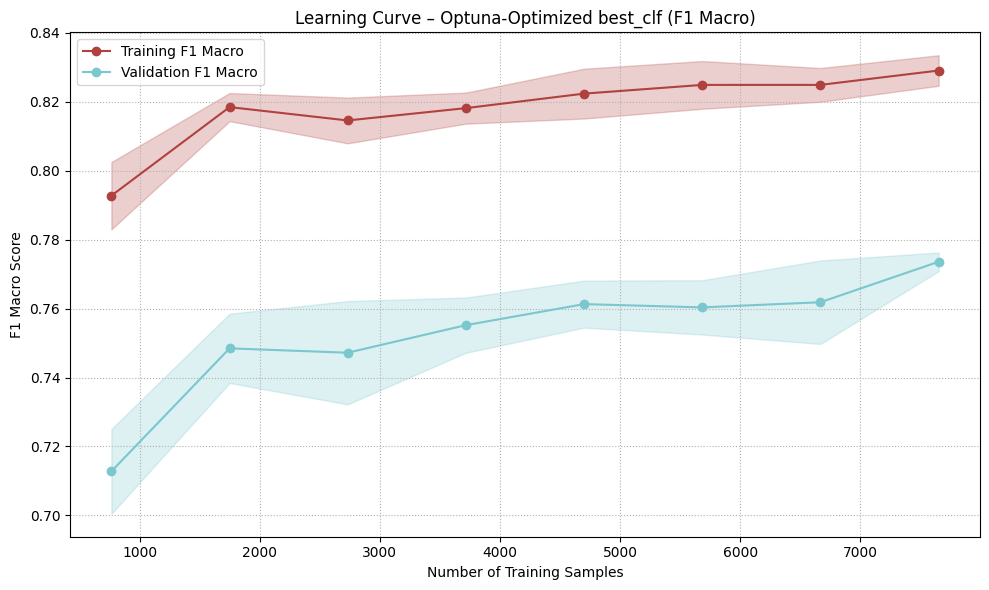

In [13]:
# ----------------------------------------------------------
# CUSTOM COLORS
# ----------------------------------------------------------
train_color = "#B0413E"  
val_color   = "#7AC7CD"  

# For fill areas: same color but transparent
train_band_color = "#B0413E55"
val_band_color   = "#7AC7CD55"

plt.figure(figsize=(10,6))

# Learning curve lines
plt.plot(train_sizes, train_mean, 'o-', label="Training F1 Macro", color=train_color)
plt.plot(train_sizes, val_mean,   'o-', label="Validation F1 Macro", color=val_color)

# Confidence bands
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.25,
    color=train_band_color
)

plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.25,
    color=val_band_color
)

# Labels & styling
plt.title(f"Learning Curve – Optuna-Optimized {model_name} (F1 Macro)")
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Macro Score")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


## 6. Revenue Regression for Classes 1 and 2 (Post-Classification Refinement)

After the main classification experiments, a second-stage regression model is trained
to estimate the continuous revenue values for classes where such prediction is
meaningful—specifically **Class 1** and **Class 2**, corresponding to moderate and high
revenue ranges.  
Class 0 is excluded because its revenue interval ($0$–$5$ USD) is too narrow to justify
a meaningful regression model.

This stage focuses on reducing overfitting and stabilizing predictions for two
heterogeneous data regimes:

- **Class 1**: many observations, moderate variance → standard tuning + bagging  
- **Class 2**: rare & heavy-tailed → winsorization + strong regularization + large bagging set  

Column-wise drift analysis (performed in `drift.ipynb`) showed instability in several
numeric variables.  
This motivates:
- log-transforming the revenue target,  
- winsorizing extreme Class 2 values,  
- applying stronger regularization,  
- and averaging predictions across multiple seeds (bagging).

The regression pipeline reports the following metrics:

### **Root Mean Squared Error (RMSE)**

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

### **Mean Absolute Error (MAE)**

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |
$$

### **Mean Absolute Percentage Error (MAPE)**

$$
\text{MAPE} =
\frac{1}{n}
\sum_{i=1}^{n}
\left|
\frac{y_i - \hat{y}_i}{y_i}
\right|
\times 100\%
$$

### **Root Mean Squared Logarithmic Error (RMSLE)**

$$
\text{RMSLE} =
\sqrt{
\frac{1}{n}
\sum_{i=1}^{n}
\left(
\log(1 + y_i)
-
\log(1 + \hat{y}_i)
\right)^2
}
$$

### **Normalised RMSE (NRMSE)**

$$
\text{NRMSE} = \frac{\text{RMSE}}{\bar{y}} \times 100\%
$$

These metrics allow comparison across revenue classes and quantify how well the
overfitting-reduction strategies improve generalization.


In [14]:
# ============================================================
# GLOBAL CONFIG
# ============================================================

drop_cols = [
    'country_name','quarters_used','volume_method','wp_m3',
    'wp_revenue_USD','target_class'
]


# ============================================================
# HELPER FUNCTIONS
# ============================================================

def _safe_pct(n, d):
    return (n / d * 100.0) if (d is not None and np.isfinite(d) and d != 0) else np.nan


def _rmsle(y_true, y_pred, clip_epsilon=0.0):
    y_true_c = np.maximum(y_true, clip_epsilon)
    y_pred_c = np.maximum(y_pred, clip_epsilon)
    return np.sqrt(np.mean((np.log1p(y_pred_c) - np.log1p(y_true_c))**2))


def _make_cv_and_groups(df_subset, n_splits=5):
    """
    Use GroupKFold if wp_id exists AND has enough unique groups, else fall back to KFold.
    """
    if 'wp_id' in df_subset.columns:
        groups_full = df_subset['wp_id'].astype(str).values
        if len(np.unique(groups_full)) >= n_splits:
            return GroupKFold(n_splits=n_splits), groups_full
    return KFold(n_splits=n_splits, shuffle=True, random_state=42), None


def _winsorize_inplace(y, lower_q=0.0, upper_q=0.99):
    """
    Clamp top tail of TRAIN ONLY to reduce variance.
    """
    lo = np.quantile(y, lower_q) if lower_q > 0 else None
    hi = np.quantile(y, upper_q) if upper_q < 1 else None
    if lo is not None:
        y = np.maximum(y, lo)
    if hi is not None:
        y = np.minimum(y, hi)
    return y

In [15]:
# ============================================================
# MAIN TRAINING FUNCTION
# ============================================================

def train_and_eval_one_class_reduce_overfit(
    subset,
    test_size=0.2,
    random_state=42,
    use_log_target=True,
    n_splits=5,
    n_iter=20,
    tune=True,
    model_params=None,
    winsorize_train_upper_q=None,
    bagging_seeds=None
):

    # -----------------------------
    # 1. Build features and target
    # -----------------------------
    X_numcat = subset.drop(columns=drop_cols)
    X = pd.get_dummies(X_numcat, drop_first=True)
    X.index = subset.index

    raw_y = subset['wp_revenue_USD'].astype(float)
    raw_y.index = subset.index

    # -----------------------------
    # 2. Train/Test split
    # -----------------------------
    all_idx = X.index.to_numpy()
    train_idx, test_idx = train_test_split(all_idx, test_size=test_size,
                                           random_state=random_state)

    X_train_df, X_test_df = X.loc[train_idx], X.loc[test_idx]
    raw_train = raw_y.loc[train_idx].values.copy()
    raw_test  = raw_y.loc[test_idx].values.copy()

    # -----------------------------
    # 3. Imputation (TRAIN ONLY)
    # -----------------------------
    imputer = SimpleImputer(strategy="median")
    X_train = imputer.fit_transform(X_train_df)
    X_test  = imputer.transform(X_test_df)

    X_train = pd.DataFrame(X_train, columns=X_train_df.columns, index=X_train_df.index)
    X_test  = pd.DataFrame(X_test,  columns=X_test_df.columns,  index=X_test_df.index)

    # -----------------------------
    # 4. Winsorize train target (optional)
    # -----------------------------
    if winsorize_train_upper_q is not None:
        raw_train = _winsorize_inplace(raw_train, upper_q=winsorize_train_upper_q)

    # -----------------------------
    # 5. Log-transform target (optional)
    # -----------------------------
    y_train_fit = np.log1p(raw_train) if use_log_target else raw_train
    y_test_fit  = np.log1p(raw_test)  if use_log_target else raw_test

    # -----------------------------
    # 6. Base model parameters
    # -----------------------------
    base_params = dict(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=4,
        min_child_weight=12,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_lambda=8.0,
        reg_alpha=0.3,
        random_state=random_state,
        n_jobs=-1,
        eval_metric="rmse"
    )

    if model_params:
        base_params.update(model_params)

    best_params = base_params.copy()

    # -----------------------------
    # 7. Hyperparameter tuning via Optuna (TRAIN ONLY)
    # -----------------------------
    if tune:
        cv, groups_full = _make_cv_and_groups(subset, n_splits=n_splits)
        groups_train = None
        if isinstance(cv, GroupKFold) and groups_full is not None:
            groups_train = pd.Series(groups_full, index=subset.index).loc[train_idx].values

        def objective(trial):
            param = {
                'n_estimators': trial.suggest_int('n_estimators', 400, 800, step=100),
                'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.05),
                'max_depth': trial.suggest_int('max_depth', 3, 5),
                'min_child_weight': trial.suggest_int('min_child_weight', 10, 16),
                'subsample': trial.suggest_float('subsample', 0.4, 0.6),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.7),
                'reg_lambda': trial.suggest_float('reg_lambda', 5.0, 12.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 0.5),
                'gamma': trial.suggest_float('gamma', 0.0, 1.0)
            }
            param.update(base_params)

            model_to_tune = XGBRegressor(**param)

            scores = cross_val_score(
                model_to_tune, X_train, y_train_fit,
                cv=cv, groups=groups_train,
                scoring='neg_mean_squared_error', n_jobs=-1
            )
            rmse = np.sqrt(-np.mean(scores))
            return rmse

        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_iter)

        best_params.update(study.best_params)

    # -----------------------------
    # 8. Fit final model(s)
    # -----------------------------
    def _fit_one(seed):
        p = dict(best_params); p["random_state"] = seed
        m = XGBRegressor(**p)
        m.fit(X_train, y_train_fit)
        return m

    models = []
    if bagging_seeds:
        for s in bagging_seeds:
            models.append(_fit_one(s))
    else:
        models.append(_fit_one(best_params.get("random_state", random_state)))

    def _avg_predict(models, Xx):
        preds = np.column_stack([m.predict(Xx) for m in models])
        return preds.mean(axis=1)

    pred_train = _avg_predict(models, X_train)
    pred_test  = _avg_predict(models, X_test)

    # -----------------------------
    # 9. Undo log transform
    # -----------------------------
    if use_log_target:
        yhat_train = np.expm1(pred_train)
        yhat_test  = np.expm1(pred_test)
    else:
        yhat_train = pred_train
        yhat_test  = pred_test

    # -----------------------------
    # 10. Metrics
    # -----------------------------
    train_r2    = r2_score(raw_train, yhat_train)
    test_r2     = r2_score(raw_test,  yhat_test)
    train_mse   = mean_squared_error(raw_train, yhat_train)
    test_mse    = mean_squared_error(raw_test,  yhat_test)
    train_rmse  = np.sqrt(train_mse)
    test_rmse   = np.sqrt(test_mse)
    train_mae   = mean_absolute_error(raw_train, yhat_train)
    test_mae    = mean_absolute_error(raw_test,  yhat_test)

    eps = 1e-6
    train_mape = np.mean(np.abs((raw_train - yhat_train) /
                                np.maximum(np.abs(raw_train), eps))) * 100.0
    test_mape = np.mean(np.abs((raw_test - yhat_test) /
                               np.maximum(np.abs(raw_test), eps))) * 100.0

    train_rmsle = _rmsle(raw_train, yhat_train)
    test_rmsle  = _rmsle(raw_test,  yhat_test)

    y_train_mean = float(np.mean(raw_train)) if len(raw_train) else np.nan
    y_test_mean  = float(np.mean(raw_test))  if len(raw_test)  else np.nan

    metrics = {
        "train_R2": train_r2, "test_R2": test_r2,
        "train_RMSE": train_rmse, "test_RMSE": test_rmse,
        "train_MAE": train_mae, "test_MAE": test_mae,
        "train_MAPE_%": train_mape, "test_MAPE_%": test_mape,
        "train_RMSLE": train_rmsle, "test_RMSLE": test_rmsle,
        "train_NRMSE_%": _safe_pct(train_rmse, y_train_mean),
        "test_NRMSE_%":  _safe_pct(test_rmse,  y_test_mean),
        "y_train_mean": y_train_mean,
        "y_test_mean":  y_test_mean,
        "n_train": len(raw_train),
        "n_test": len(raw_test),
        "used_log_target": use_log_target,
        "best_params": best_params,
        "bagged_models": len(models),
        "winsorized_train_upper_q": winsorize_train_upper_q
    }

    return (models if bagging_seeds else models[0]), metrics

In [16]:
# ============================================================
# RUN MODELS FOR CLASS 1 AND CLASS 2 ONLY
# ============================================================

class_1 = df[df["target_class"] == 1]
class_2 = df[df["target_class"] == 2]

# --------------------------
# Class 1 (balanced class)
# --------------------------
model1, m1 = train_and_eval_one_class_reduce_overfit(
    class_1,
    tune=True,
    n_iter=20,
    bagging_seeds=[11, 22, 33, 44, 55]
)

# --------------------------
# Class 2 (rare, heavy tails → winsorize + stronger regularization)
# --------------------------
model2, m2 = train_and_eval_one_class_reduce_overfit(
    class_2,
    tune=True,
    n_iter=30,
    winsorize_train_upper_q=0.98,  # clamp top 2% of TRAIN
    bagging_seeds=[11,22,33,44,55,66,77],
    model_params=dict(
        max_depth=2,             # ↓ smaller trees → less overfitting
        min_child_weight=20,     # ↑ minimum samples for split → more generalization
        subsample=0.6,
        colsample_bytree=0.6,
        colsample_bynode=0.5,    # extra randomness → reduces variance
        reg_lambda=20.0,         # strong L2 regularization
        reg_alpha=1.0,           # L1 regularization → sparsity
        n_estimators=300         # fewer trees → less variance
    )
)

# ============================================================
# SUMMARY TABLE (ONLY CLASS 1 AND CLASS 2)
# ============================================================

summary = pd.DataFrame(
    [
        {"class": 1, **m1},
        {"class": 2, **m2}
    ]
).set_index("class")

summary = summary[
    [
        "used_log_target","bagged_models","winsorized_train_upper_q",
        "train_R2","test_R2","train_RMSE","test_RMSE",
        "train_MAE","test_MAE",
        "train_MAPE_%","test_MAPE_%",
        "train_RMSLE","test_RMSLE",
        "train_NRMSE_%","test_NRMSE_%",
        "y_train_mean","y_test_mean",
        "n_train","n_test","best_params"
    ]
].round(4)

In [17]:
summary.T

class,1,2
used_log_target,True,True
bagged_models,5,7
winsorized_train_upper_q,NaN,0.98
train_R2,0.5966,0.7866
test_R2,0.5194,0.6212
train_RMSE,50.3059,2011.1306
test_RMSE,55.6534,3348.0957
train_MAE,28.1753,1097.7977
test_MAE,31.7302,1714.1568
train_MAPE_%,58.1649,32.3952


| Topic                               | Key Insight                                                                 |
|-------------------------------------|------------------------------------------------------------------------------|
| Temporal Drift                      | Older data reduces predictive accuracy; yearly distributions shift notably. |
| Cross-Country Drift                 | Zero-shot generalisation is weak; models do not transfer reliably.          |
| Calibration Requirement             | ~200 labelled rows typically restore 95% of achievable F1-macro.            |
| Class Structure                     | Continuous revenue is meaningful only for Classes 1 and 2.                  |
| Tail Behaviour                      | Class 2 shows heavy tails → needs winsorisation + log transform + bagging. |
| Best Classification Strategy        | Decision Tree + Optuna tuning + drift monitoring.                          |
| Best Regression Strategy            | XGBoost with class-specific tuning and strong regularisation.               |
| Deployment Recommendation           | Calibrate per country; re-evaluate drift annually or quarterly.             |
